# Module import

In [1]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tf
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image

#Import data

In [6]:
#import shutil

#shutil.rmtree('./CIFAKE')

In [7]:
!git clone https://github.com/jordan-bird/CIFAKE-Real-and-AI-Generated-Synthetic-Images.git CIFAKE

Cloning into 'CIFAKE'...
remote: Enumerating objects: 118688, done.
remote: Counting objects: 100% (118688/118688), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 118688 (delta 118649), reused 118673 (delta 118645), pack-reused 0
Receiving objects: 100% (118688/118688), 39.68 MiB | 30.95 MiB/s, done.
Resolving deltas: 100% (118649/118649), done.
Updating files: 100% (120001/120001), done.


## Prepare train/test data

In [8]:
TRAIN_ANNO_PATH = "train_labels.csv"

In [10]:
train_paths_fake = list(glob('./CIFAKE/DATASET/train/FAKE/*.jpg'))
print(len(train_paths_fake))

df_train_fake = pd.DataFrame(train_paths_fake)
df_train_fake.columns = ['path']
df_train_fake['label'] = 0
df_train_fake.head()

train_paths_real = list(glob('./CIFAKE/DATASET/train/REAL/*.jpg'))
print(len(train_paths_real))

df_train_real = pd.DataFrame(train_paths_real)
df_train_real.columns = ['path']
df_train_real['label'] = 1
df_train_real.head()

df_train = pd.concat((df_train_fake, df_train_real), axis = 0 )
print(df_train.shape)

df_train.to_csv(TRAIN_ANNO_PATH, index=False)

50000
50000
(100000, 2)


In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
      self.img_labels = dataframe
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
training_data = CustomImageDataset(pd.read_csv(TRAIN_ANNO_PATH), "", transform=lambda img: img.type(torch.FloatTensor))
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

## Model

In [13]:
NUM_EPOCHS = 1

In [14]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Sequential model
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(32 * 8 * 8, 2),
    nn.Sigmoid(),
)

# Initialize the weights of the model
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(weights_init)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



### Sanity check

In [15]:
sample_loader = DataLoader(training_data, batch_size=5, shuffle=True)


In [16]:
sample_batch = next(iter(sample_loader))

In [17]:

# Data loading check

sample_images, sample_labels = sample_batch

# Verify data loading
print("Sample images shape:", sample_images.shape)
print("Sample labels:", sample_labels)

# Model forward pass check
sample_images = sample_images.to(device)  # Move sample images to GPU if applicable
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    sample_outputs = model(sample_images)

# Verify model output
print("Sample outputs shape:", sample_outputs.shape)
print("Sample outputs:", sample_outputs)


Sample images shape: torch.Size([5, 3, 32, 32])
Sample labels: tensor([1, 1, 1, 0, 0])
Sample outputs shape: torch.Size([5, 2])
Sample outputs: tensor([[1.0000e+00, 6.4018e-06],
        [1.0000e+00, 6.0825e-04],
        [1.0000e+00, 9.9982e-01],
        [1.0000e+00, 7.2147e-14],
        [1.0000e+00, 2.9780e-06]], device='cuda:0')


In [18]:
losses = []

# Assuming train_loader provides batches of input data and corresponding sample_labels
for epoch in range(5):
    epoch_loss = 0.0  # Initialize epoch loss

    # Move sample_images and labels to the GPU
    inputs, labels = sample_images.to(device), sample_labels.to(device)

    optimizer.zero_grad()  # Zero the gradients
    outputs = model(inputs)  # Forward pass

    loss = criterion(outputs, labels)  # Calculate loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights based on gradients

    # Accumulate epoch loss
    epoch_loss += loss.item()

    # Optionally, print the loss

    # Calculate average epoch loss and store it
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Epoch Loss: {avg_epoch_loss:.4f}")


Epoch [1/1], Average Epoch Loss: 0.0005
Epoch [2/1], Average Epoch Loss: 0.0004
Epoch [3/1], Average Epoch Loss: 0.0004
Epoch [4/1], Average Epoch Loss: 0.0004
Epoch [5/1], Average Epoch Loss: 0.0004


In [19]:
losses = []

# Assuming train_loader provides batches of input data and corresponding labels
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0  # Initialize epoch loss
    for i, data in enumerate(train_dataloader, start=0):
        inputs, labels = data  # Get inputs and corresponding labels

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights based on gradients

        # Accumulate epoch loss
        epoch_loss += loss.item()

        # Optionally, print the loss
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Calculate average epoch loss and store it
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Epoch Loss: {avg_epoch_loss:.4f}")


Epoch [1/1], Batch [1/1563], Loss: 0.6931
Epoch [1/1], Batch [11/1563], Loss: 0.6931
Epoch [1/1], Batch [21/1563], Loss: 0.6931
Epoch [1/1], Batch [31/1563], Loss: 0.6931
Epoch [1/1], Batch [41/1563], Loss: 0.6931
Epoch [1/1], Batch [51/1563], Loss: 0.6931
Epoch [1/1], Batch [61/1563], Loss: 0.6931
Epoch [1/1], Batch [71/1563], Loss: 0.6931
Epoch [1/1], Batch [81/1563], Loss: 0.6931
Epoch [1/1], Batch [91/1563], Loss: 0.6931
Epoch [1/1], Batch [101/1563], Loss: 0.6931
Epoch [1/1], Batch [111/1563], Loss: 0.6931
Epoch [1/1], Batch [121/1563], Loss: 0.6931
Epoch [1/1], Batch [131/1563], Loss: 0.6931
Epoch [1/1], Batch [141/1563], Loss: 0.6931
Epoch [1/1], Batch [151/1563], Loss: 0.6931
Epoch [1/1], Batch [161/1563], Loss: 0.6931
Epoch [1/1], Batch [171/1563], Loss: 0.6931
Epoch [1/1], Batch [181/1563], Loss: 0.6931
Epoch [1/1], Batch [191/1563], Loss: 0.6931
Epoch [1/1], Batch [201/1563], Loss: 0.6931
Epoch [1/1], Batch [211/1563], Loss: 0.6931
Epoch [1/1], Batch [221/1563], Loss: 0.6931

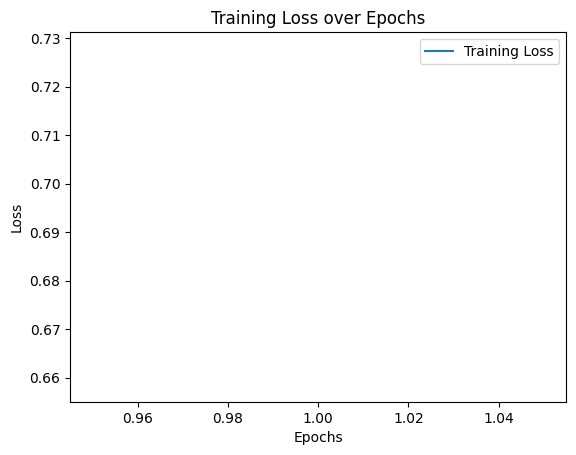

In [20]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.plot(range(1, NUM_EPOCHS + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()
